# Loading Individual Test Data From Array -- Development

WNixalo - 05 Jan 2018

Working on real-time model operation. I looked through the Fast.ai library code for learner.py, conv_learner.py, dataset.py, and dataloader.py, and it looks like Fast.ai requires the specification of training data. The out-layer size is determined by the Tensor shape of the first datum in `trn[0]`, the training dataset.

So I could ask around on the forums, rewrite as much as I need (for instance, could Tensor shape just be specified when the learner is initalized, instead of being automatically inferred from the dataset? I believe Keras' model classes are more self-contained in this regard, although Keras was designed for much more static architectures, before full-Convnets came abobut..

I'm going to take the easiest option. If it's worth doing, I'll work on an extension or something for Fast.ai afterwards, but I want to get this project done; it's been about a month now. I'll just specify a training set, and make sure there is some training folder on the system.

Now to get `ImageClassifierData.from_arrays(.)` to work.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai_osx.model import resnet34
from fastai_osx.conv_learner import * # imports learner -> imports dataset & imports

In [3]:
PATH = 'data/'
# labels_csv = PATH+'labels.csv'
# val_idxs = [0]

In [18]:
# get random image
tpath = 'data/train/'
if '.DS_Store' in os.listdir(tpath):
    os.remove(tpath + '.DS_Store')
folders = os.listdir(tpath)
folder  = np.random.choice(folders)
fname   = np.random.choice(os.listdir(tpath+folder))
fpath   = tpath+folder+'/'+fname; fpath

# load image as ndarray
image = cv2.imread(fpath) # dtype = 'uint8'
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB conversion

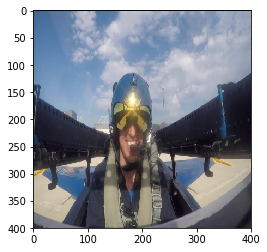

In [19]:
plt.imshow(image)

**NOTE**: aha, that makes sense. You can go back and forth even by just running RGB2BGR or its counterpart twice.

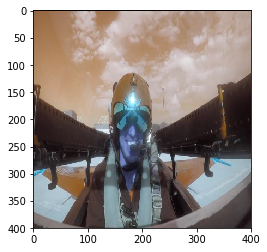

In [20]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

**NOTE** here: remember to convert the color channel of images read via OpenCV from BGR to RGB.

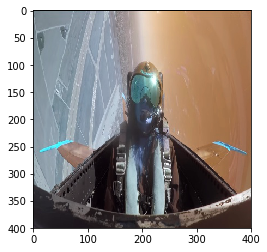

In [13]:
# plt.imshow(image)

In [14]:
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

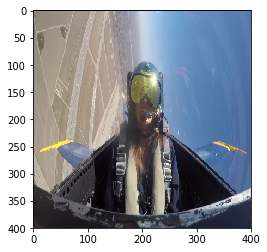

In [15]:
# plt.imshow(image)

In [37]:
# %timeit image = cv2.imread(fpath)
# %timeit image = np.array(Image.open(fpath))

2.41 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.89 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
image.shape # PyTorch Tensor would be (3, 400, 400)

(400, 400, 3)

In [48]:
image[:100,:].shape # so I can better track np.rollaxis

(100, 400, 3)

In [49]:
np.rollaxis(image[:100,:], 2, 0).shape # great: working as advertised

(3, 100, 400)

In [23]:
image.shape

(400, 400, 3)

In [24]:
image = np.rollaxis(image, 2, 0)

In [25]:
image.shape

(3, 400, 400)

In [26]:
labels_df = pd.read_csv(PATH + 'labels.csv')

In [27]:
labels_df.columns

Index(['id', 'gloc'], dtype='object')

In [28]:
labels_df['id'].head()

0    000000-000412/000000
1    000000-000412/000001
2    000000-000412/000002
3    000000-000412/000003
4    000000-000412/000004
Name: id, dtype: object

In [60]:
folder

'005452-005591'

In [63]:
# see: https://stackoverflow.com/questions/17071871/select-rows-from-a-dataframe-based-on-values-in-a-column-in-pandas
labels_df.loc[labels_df['id'] == folder+'/'+fname.split('.')[0]]

,id,gloc
5524,005452-005591/005524,1


In [66]:
x = labels_df.loc[labels_df['id'] == folder+'/'+fname.split('.')[0]]['gloc']

In [74]:
x.values, x.values[0]

(array([1]), 1)

In [29]:
image_label = labels_df.loc[labels_df['id']==folder+'/'+fname.split('.')[0]]['gloc'].values[0]

In [30]:
image_label

0

In [31]:
# PyTorch Tensor shape: (N, Channels, Rows, Cols) # or (,,X,Y)?
train_dat = (np.array([image]), np.array([image_label]))

In [32]:
train_dat[0].shape, train_dat[1].shape

((1, 3, 400, 400), (1,))

I'll just make `val_dat` a copy of `train_dat` since Fast.ai requires it, but I'm only running this as testing. Had trouble copying tuple of ndarrays so just this for now.

In [33]:
val_dat = train_dat

To see if this works, before testing real-time test-data, just set `test_dat = None`

In [34]:
test_dat = None
classes = [0,1]

In [35]:
sz = 400
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.2)

# ImageClassifierData.from_arrays(path, trn, val, bs=64, tfms=(None, None), 
#                                   classes=None, num_workers=4, test=None)
data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1, 
                                       tfms=tfms, classes=classes, test=test_dat)

learner = ConvLearner.pretrained(resnet34, data)

In [99]:
# idk if I was supposed to make these strings, or ints, or floats..
data.classes

[0, 1]

In [107]:
x = data.trn_ds.get_x(0); x.shape

(3, 400, 400)

Think I have to convert this back to `(H,W,C)` in order to display it here.

In [113]:
x[:,:100,:].shape

(3, 100, 400)

In [118]:
np.rollaxis(x[:,:100,:], 0,3).shape # this works? Why 3 & not 2? [0,1,2]??

(100, 400, 3)

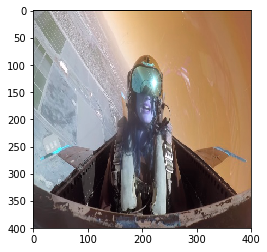

In [119]:
plt.imshow(np.rollaxis(x, 0,3))

This is great. I just forgot that OpenCV treats color channels in BGR format instead of RGB. I'll test that now to make sure. Yup: confirmed:

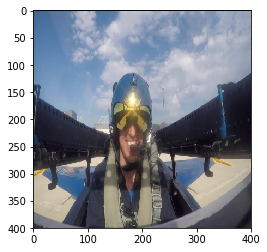

In [43]:
plt.imshow(np.rollaxis(data.trn_ds.get_x(0), 0,3))

Testing that the learner works. Resizing to a tiny size like 10x10 isn't working on my MacBook (see down below for the 2 errors). Trying to fit one epoch ended up killing the kernel, and I'm guessing it was taking too much RAM, though I didn't check.

I can check that out on my GPU Linux machine, though, with a training set size of `1`, who knows what kind of weird things may happen -- well, without enough famliarity with the Fast.ai library.

I can test that later, here what I want is to see if I can generate predictions for *test* data. So let's see.

In [52]:
def get_image_ndarray(path='data/train/'):
    # get random image
    if '.DS_Store' in os.listdir(path):
        os.remove(tpath + '.DS_Store')
    folders = os.listdir(tpath) # oops path, not tpath
    folder  = np.random.choice(folders)
    fname   = np.random.choice(os.listdir(path+folder)) # oops path, not tpath
    fpath   = path+folder+'/'+fname; fpath

    # load image as ndarray
    image = cv2.imread(fpath) # dtype = 'uint8'
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB conversion
    
    # reshape image to PyTorch Tensor Order: (Channel,H,W)
    image = np.rollaxis(image, 2, 0)
    
    # return image as ndarray of ndarrays
    return np.array([image])

def check_ndarray_image(image_ndarray):
    plt.imshow(np.rollaxis(image_ndarray[0], 0, 3))

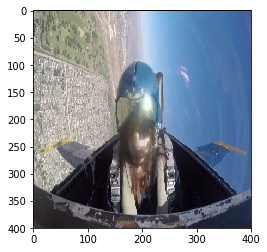

In [53]:
check_ndarray_image(get_image_ndarray())

Okay so that works. Now to chuck it into the neural net. I think there may be a way to manually package the image I want to test on as a `fastai.dataset.ModelData` or `fastai.dataset.ImageData` class variable and set `data.test_dl` or something along those lines to it.. but I'm not sure just yet.

In [56]:
# get a random dataset image as test data
test_dat = get_image_ndarray()
data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1, 
                                       tfms=tfms, classes=classes, test=test_dat)

In [57]:
learner.set_data(data)

In [58]:
result = learner.TTA(is_test=True)

ValueError: operands could not be broadcast together with shapes (400,400,400) (3,) 

Oookay.. what if I just tried sending a default color-channel-orderedd image in?

In [62]:
image = np.rollaxis(test_dat[0],0,3); image.shape

(400, 400, 3)

In [63]:
test_dat = np.array([image])
data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1, 
                                       tfms=tfms, classes=classes, test=test_dat)
learner.set_data(data)

In [64]:
learner.TTA(is_test=True)

(array([[[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]],
 
        [[ 0.]]], dtype=float32), array([[ 0.]]))

Looks like I never needed to change the color channels at all..... is that right?

I wonder.. wait well shit is the Fast.ai dataloader handling that for me already? A quick check could test that:

**Edit**: right. Not working, same *size [1, 1024]* error. Will need to check that later.

In [81]:
result,_  = learner.TTA(is_test=True)

In [82]:
result

array([[[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]],

       [[ 0.]]], dtype=float32)

In [86]:
np.mean(np.exp(result), 0)

array([[ 1.]], dtype=float32)

Aaalrighty... so it looks like it found a thing. The real way to test this is to load the finetuned weights, which already have a very high training-set accuracy, and see if they get it right more often than not. Here we go.

In a second notebook.

---
I just noticed something. There may be an easy way to load test data dynamically, but with a very tried-and-tested method, like `.from_csv(.)`: I can just save each image to a temporary test folder, reload the dataloader, and test on that. That's a thought.

`Wayne Nixalo -- 23:41 - 05 Jan 2018`

In [92]:
def ret2():
    return 1, 2

x = ret2()[0], 3; x

(1, 3)

## Errors Training (MacBook CPU) on 1-image

Interesting Error. PyTorch wants `(Channel, Height, Width)`, but the Fast.ai resize function seems to be assuming `(Height, Width, Channel)` ..

Wait is it Height,Width or Width,Height? Well that's not important for here at least.

In [ ]:
# train_dat = (np.array([image]), np.array([image_label]))
# train_dat[0].shape, train_dat[1].shape --> ((1, 3, 400, 400), (1,))
tfms = tfms_from_model(resnet34, 10, aug_tfms=transforms_side_on, max_zoom=1.2)
data = ImageClassifierData.from_arrays(PATH, train_dat, val_dat, bs=1, 
                                       tfms=tfms, classes=classes, test=test_dat)
learner = ConvLearner.pretrained(resnet34, data)

In [31]:
learner.fit(lrs=1e-6, n_cycle=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (10,10,400) (3,) 

If I instead leave the shape of `image` unchanged after loading, I get this error instead:

In [41]:
learner.fit(lrs=1e-6, n_cycle=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/1 [00:00<?, ?it/s]


ValueError: Expected more than 1 value per channel when training, got input size [1, 1024]

## An older PIL/Pillow import issue (resolved)

Some PIL/Pillow Issue: -- see [forum post](http://forums.fast.ai/t/another-treat-early-access-to-intro-to-machine-learning-videos/6826/281)

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
from fastai_osx.imports import *
from fastai_osx.conv_learner import *
from fastai_osx.model import *
from fastai_osx.torch_imports import *

from utils.subfolder_val_loader import set_cv_idxs

/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/PIL/Image.py:78: RuntimeWarning: The _imaging extension was built for another version of Pillow or PIL:
Core version: 4.3.0
Pillow version: 4.3.0.post0
  warnings.warn(str(v), RuntimeWarning)


ImportError: The _imaging extension was built for another version of Pillow or PIL:
Core version: 4.3.0
Pillow version: 4.3.0.post0

In [2]:
from PIL import Image

In [4]:
from fastai_osx.conv_learner import *
from fastai_osx.imports import *